In [1]:
pip install dtw-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 5.8 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='index', ylabel='value'>

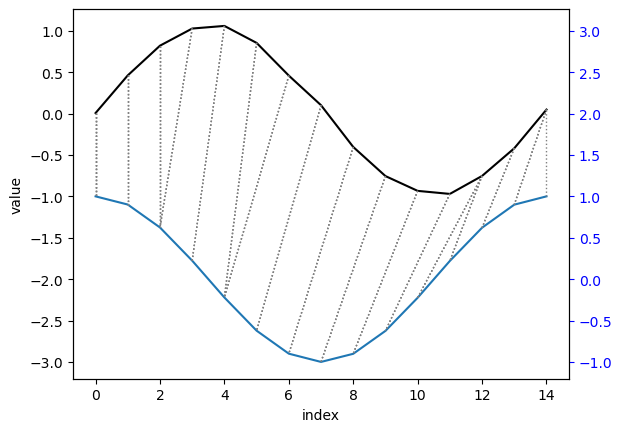

In [64]:
import numpy as np

## A noisy sine wave as query
idx = np.linspace(0,6.28,num=15)
query = np.sin(idx) + np.random.uniform(size=15)/10.0

## A cosine is for template; sin and cos are offset 1/4th samples
template = np.cos(idx)

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
#alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
p= dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

p.set_xlabel('index')
p.set_ylabel('value')

p

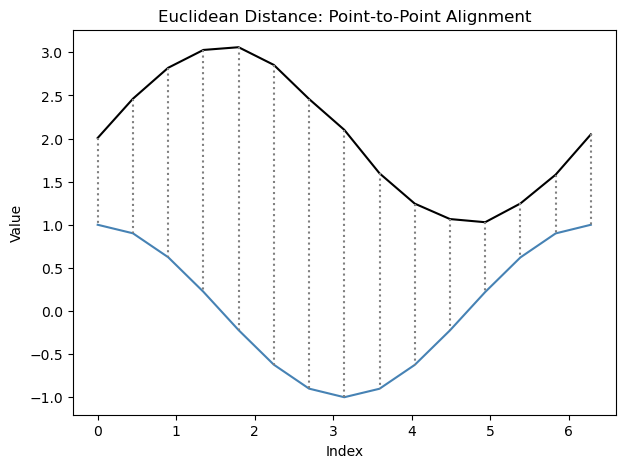

In [65]:
import matplotlib.pyplot as plt


# Create a figure to plot the Euclidean Distance
plt.figure(figsize=(7,5))

query_translated = query + 2

# Plot the query (sine) and template (cosine)
plt.plot(idx, query_translated , label='Query (Sine)', color='black')
plt.plot(idx, template, label='Template (Cosine)',  color='steelblue')

# Add lines connecting corresponding points (Euclidean Distance lines)
for i in range(15):
    plt.plot([idx[i], idx[i]], [query_translated[i], template[i]], color='gray', linestyle='dotted')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Euclidean Distance: Point-to-Point Alignment')

# Show the plot
plt.show()

In [66]:
# Populate the DTW matrix
def populate_dtw_matrix(matrix, trajectoryA, trajectoryB):
    n, m = len(trajectoryA), len(trajectoryB)
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = euclidean_distance(trajectoryA[i-1], trajectoryB[j-1])
            matrix[i, j] = cost + min(
                matrix[i-1, j-1],  # match
                matrix[i-1, j],    # deletion A
                matrix[i, j-1])    # deletion B
    return matrix

# Populate the Fréchet matrix
def populate_dfd_matrix(matrix, trajectoryA, trajectoryB):
    n, m = len(trajectoryA), len(trajectoryB)
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = euclidean_distance(trajectoryA[i-1], trajectoryB[j-1])
            matrix[i, j] = max(cost, min(
                matrix[i-1, j-1],  # match
                matrix[i-1, j],    # deletion A
                matrix[i, j-1]))   # deletion B
    return matrix


# Populate the TWED matrix
def populate_twed_matrix(matrix, trajectoryA, trajectoryB, lambda_penalty, nu_elasticity):
  n, m = len(trajectoryA), len(trajectoryB)
  for i in range(1, n+1):
    for j in range(1, m+1):
      cost = euclidean_distance(trajectoryA[i-1], trajectoryB[j-1])
      matrix[i, j] = cost + min(
        matrix[i-1, j-1] + lambda_penalty,  # match with penalty
        matrix[i-1, j] + lambda_penalty + nu_elasticity,  # delete from A
        matrix[i, j-1] + lambda_penalty + nu_elasticity   # delete from B
      )
  return matrix

In [67]:
import numpy as np

# Define the points for the two trajectories
trajectoryA = [(0, 1), (4, 0), (5, 1), (9, 1)]
trajectoryB = [(1, 2), (0, 4), (9, 2)]

# Create a function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Initialize DTW matrix with infinity
n, m = len(trajectoryA), len(trajectoryB)
dtw_matrix = np.full((n+1, m+1), np.inf)
dtw_matrix[0, 0] = 0

# Populate the DTW matrix
dtw_matrix = populate_dtw_matrix(dtw_matrix, trajectoryA, trajectoryB)

                                      
# Set print options to limit decimals            
np.set_printoptions(precision=2, suppress=True)
# Print the DP matrix
print(dtw_matrix)


[[ 0.     inf   inf   inf]
 [  inf  1.41  4.41 13.47]
 [  inf  5.02  7.07  9.8 ]
 [  inf  9.14 10.85 11.19]
 [  inf 17.21 18.63 11.85]]


In [68]:
import numpy as np

# Define the points for the two trajectories
trajectoryA = [(0, 1), (4, 0), (5, 1), (9, 1)]
trajectoryB = [(1, 2), (0, 4), (9, 2)]

# Create a function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
  return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Initialize Fréchet matrix with infinity
n, m = len(trajectoryA), len(trajectoryB)
frechet_matrix = np.full((n+1, m+1), np.inf)
frechet_matrix[0, 0] = 0

# Populate the Fréchet matrix
dfd_matrix = populate_dfd_matrix(frechet_matrix, trajectoryA, trajectoryB)


# Set print options to limit decimals
np.set_printoptions(precision=2, suppress=True)
# Print the Fréchet matrix
print(frechet_matrix)

[[0.    inf  inf  inf]
 [ inf 1.41 3.   9.06]
 [ inf 3.61 5.66 5.39]
 [ inf 4.12 5.83 5.39]
 [ inf 8.06 9.49 5.39]]


In [69]:
import numpy as np

# Define the points for the two trajectories
trajectoryA = [(0, 1), (4, 0), (5, 1), (9, 1)]
trajectoryB = [(1, 2), (0, 4), (9, 2)]
lambda_penalty = 0.5  # Penalty parameter for insertion/deletion
nu_elasticity = 1   # Elasticity parameter


# Create a function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
  return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Initialize Fréchet matrix with infinity
n, m = len(trajectoryA), len(trajectoryB)
twed_matrix = np.full((n+1, m+1), np.inf)
twed_matrix[0, 0] = 0

# Populate the Fréchet matrix
twed_matrix = populate_twed_matrix(twed_matrix, trajectoryA, trajectoryB, lambda_penalty, nu_elasticity)
np.set_printoptions(precision=2, suppress=True)
print("TWED Matrix:")
print(twed_matrix)



TWED Matrix:
[[ 0.     inf   inf   inf]
 [  inf  1.91  6.41 16.97]
 [  inf  7.02  8.07 12.3 ]
 [  inf 12.64 13.35 12.69]
 [  inf 22.21 22.63 14.85]]
